In [1]:
import json
import pandas as pd

models = ['original', 'llama_7B', 'llama_13B', 'llama_30B', 'llama_65B', 'mistral_7B', 'falcon_7B']

base_path = '' # select your data

df_dict = {}

for model in models:
    file_path = f'{base_path}/{model}/articles.json'
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            df_dict[model] = pd.DataFrame(data)
    except Exception as e:
        print(f"Failed to load data for {model}: {e}")

df_dict['original']



In [7]:
test_article = data_dict['falcon_7B'][0]

In [8]:
test_article['constituents']

['(ROOT (S (NP (NP (NNP Senator) (NNP Ben) (NNP Cardin)) (-LRB- -LRB-) (NP (NNP D) (HYPH -) (NNP MD)) (-RRB- -RRB-)) (VP (VBZ has) (VP (VBN threatened) (S (VP (TO to) (VP (VB block) (NP (NP (JJ further) (JJ military) (NN aid)) (PP (IN to) (NP (NNP Egypt))))))))) (. .)))',
 '(ROOT (S (NP (DT This)) (VP (VBZ follows) (NP (NP (DT a) (NN statement)) (PP (IN by) (NP (NML (JJ Egyptian) (NNP President)) (NNP Abdel) (NNP Fattah) (NNP el) (HYPH -) (NNP Sisi))) (SBAR (IN that) (S (NP (NNP Egypt)) (VP (MD will) (ADVP (RB no) (RBR longer)) (VP (VB accept) (NP (NNP U.S.) (NN aid)))))))) (. .)))']

In [9]:
from crawl_articles import dates_from_dict

for lm in data_dict:
    print(f'{lm}: {dates_from_dict(data_dict[lm])}, {len(data_dict[lm])}')

original: ('2024-01-24T08:39:00+0000', '2023-10-01T00:06:00+0000'), 13771
llama_7B: ('2024-01-24T08:39:00+0000', '2023-10-01T00:06:00+0000'), 13771
llama_13B: ('2024-01-24T08:39:00+0000', '2023-10-01T00:06:00+0000'), 13771
llama_30B: ('2024-01-24T08:39:00+0000', '2023-10-01T00:06:00+0000'), 13771
llama_65B: ('2024-01-24T08:39:00+0000', '2023-10-01T00:06:00+0000'), 13771
mistral_7B: ('2024-01-24T08:39:00+0000', '2023-10-01T00:06:00+0000'), 13771
falcon_7B: ('2024-01-24T08:39:00+0000', '2023-10-01T00:06:00+0000'), 13771


In [10]:
from constituency import *
#

def return_constituents(data_dict):
    """
    Return a dictionary with the parses for each language model at token or sentence level
    """
    const_dict = {}
    for lm in data_dict.keys():
        const_dict[lm] = []
        for article in data_dict[lm]:
            for sentence in article['constituents']:
                const_dict[lm].append(sentence)

    return const_dict


const_dict = return_constituents(data_dict)

span_dict = {}
for lm in const_dict.keys():
    span_dict[lm] = []
    for sentence in tqdm(const_dict[lm]):
        try:
            span_dict[lm].append(get_tree_spans(Tree.fromstring(sentence, remove_empty_top_bracketing=True), True))
        except ValueError:
            print(sentence)
        
      

100%|██████████| 27867/27867 [00:05<00:00, 5295.95it/s]


In [11]:
span_len_dict = {}
for lm in span_dict.keys():
    span_len_dict[lm] = []
    for sentence in tqdm(span_dict[lm]):
        for span in sentence:
            span_len = len(span[0])
            span_len_dict[lm].append(span_len)

100%|██████████| 27867/27867 [00:00<00:00, 151735.77it/s]


In [12]:
def spans_per_length(span_dict, max_length, step):
    spans_per_length = {}
    for lm in span_dict.keys():
        spans_per_length[lm] = {}
        for i in range(1, max_length, step):
            key = f'{i}_{i+step-1}' if i+step-1 < max_length else f'{i}_'
            spans_per_length[lm][key] = []


        for key in spans_per_length[lm].keys():
            upper = int(key.split('_')[1]) if key.split('_')[1] != '' else max_length
            lower = int(key.split('_')[0]) if key.split('_')[0] != '' else 1
            for sentence in span_dict[lm]:
                try:
                    if lower <= len(sentence[0][0]) <= upper:
                        spans_per_length[lm][key].append(sentence)
                except IndexError:
                    pass
    return spans_per_length

def len_sequence_parts(sequence):
    lengths = []
    for part in sequence:
        lengths.append(len(part[0]))
    return lengths

spans_per_length_dict = spans_per_length(span_dict, 50, 10)

span_lengths = {}
for key in spans_per_length_dict.keys():
    span_lengths[key] = {}
    for length in spans_per_length_dict[key].keys():
        span_lengths[key][length] = []
        span_lengths[key][length] = [len_sequence_parts(sentence) for sentence in spans_per_length_dict[key][length]]
        for sentence in spans_per_length_dict[key][length]:
            span_lengths[key][length] += len_sequence_parts(sentence)
        # join lists
        span_lengths[key][length] = [item for sublist in span_lengths[key][length] for item in (sublist if isinstance(sublist, list) else [sublist])]

In [13]:
for lm in span_lengths.keys():
    print(lm)
    for length in span_lengths[lm].keys():
        print(length)
        print(f"Average length: {round(np.mean(span_lengths[lm][length]), 2)}")
        print(f"Standard deviation: {round(np.std(span_lengths[lm][length]), 2)}")
        print(f"Number of sentences: {len(spans_per_length_dict[lm][length])}")
    print('-----------------------------------')

original
1_10
Average length: 4.32
Standard deviation: 2.35
Number of sentences: 4679
11_20
Average length: 6.37
Standard deviation: 4.64
Number of sentences: 6180
21_30
Average length: 7.9
Standard deviation: 6.97
Number of sentences: 6154
31_40
Average length: 9.38
Standard deviation: 9.19
Number of sentences: 4770
41_
Average length: 10.6
Standard deviation: 11.24
Number of sentences: 2966
-----------------------------------
llama_7B
1_10
Average length: 4.4
Standard deviation: 2.35
Number of sentences: 6039
11_20
Average length: 6.57
Standard deviation: 4.69
Number of sentences: 12362
21_30
Average length: 8.33
Standard deviation: 6.99
Number of sentences: 11014
31_40
Average length: 9.89
Standard deviation: 9.24
Number of sentences: 5789
41_
Average length: 11.19
Standard deviation: 11.35
Number of sentences: 2035
-----------------------------------
llama_13B
1_10
Average length: 4.4
Standard deviation: 2.33
Number of sentences: 6627
11_20
Average length: 6.55
Standard deviation: 

In [14]:
import nltk
non_terminals_feq_dict = {}

for lm in const_dict.keys():
    non_terminals_feq_dict[lm] = []
    for tree in tqdm(const_dict[lm]):  
        parse_tree = nltk.Tree.fromstring(tree)
        non_terminals = [subtree.label() for subtree in parse_tree.subtrees() if subtree.height() > 2]
        freq_dist = nltk.FreqDist(non_terminals)
        non_terminals_feq_dict[lm].append(freq_dist)

100%|██████████| 27867/27867 [00:04<00:00, 5635.77it/s]


In [15]:
def_feq_dict = {}
for lm in non_terminals_feq_dict.keys():
    def_feq_dict[lm] = {}
    for tree in non_terminals_feq_dict[lm]:
        for symbol in tree:
            if symbol == 'ROOT':    
                continue
            if symbol not in def_feq_dict[lm] and symbol:
                def_feq_dict[lm][symbol] = 0
            def_feq_dict[lm][symbol] += tree[symbol]
# normalize the def_feq_dict
for lm in def_feq_dict.keys():
    total = 0
    for symbol in def_feq_dict[lm]:
        total += def_feq_dict[lm][symbol]
    for symbol in def_feq_dict[lm]:
       #def_feq_dict[lm][symbol] /= len(non_terminals_feq_dict[lm])
        def_feq_dict[lm][symbol] /= total
        def_feq_dict[lm][symbol] *= 100


print(def_feq_dict['llama_7B'])

{'NP': 40.16637692106886, 'VP': 20.177679776497836, 'S': 13.091733641407885, 'PP': 12.907333248168493, 'SBAR': 4.34062973845137, 'NML': 1.427714490427287, 'ADJP': 1.7848513966108097, 'WHNP': 1.5905922474075636, 'WHADVP': 0.6519275950745099, 'ADVP': 2.5034297362296782, 'QP': 0.36560710496936843, 'CONJP': 0.05026576984387063, 'PRT': 0.38935143271329625, 'WHPP': 0.03707447665279961, 'INTJ': 0.038740745266408576, 'FRAG': 0.06859472459356931, 'UCP': 0.014579850369078499, 'PRN': 0.023466616308326343, 'SINV': 0.07970318201762913, 'WHADJP': 0.02318890487272485, 'LST': 0.0048599501230261665, 'SQ': 0.15038074237820964, 'SBARQ': 0.09844870392073005, 'X': 0.012635870319868034, 'RRC': 0.0008331343068044856}


In [16]:

# plot non-terminal frequencies
df = pd.DataFrame(columns=['lm', 'symbol', 'count'])
for lm in def_feq_dict.keys():
    for symbol, count in def_feq_dict[lm].items():
        df = pd.concat([df, pd.DataFrame({'lm': lm, 'symbol': symbol, 'count': count}, index=[0])], ignore_index=True)

df = df.pivot(index='symbol', columns='lm', values='count')

# order by original
df = df.sort_values(by='original', ascending=False)
# select only those bigger than 1%
df = df[df['original'] > 1]

# calculate relative to original
relative_df = df.copy()
relative_df['llama_7B'] = df['llama_7B']/df['original']
relative_df['llama_13B'] = df['llama_13B']/df['original']
relative_df['llama_30B'] = df['llama_30B']/df['original']
relative_df['llama_65B'] = df['llama_65B']/df['original']
relative_df['mistral_7B'] = df['mistral_7B']/df['original']
relative_df['falcon_7B'] = df['falcon_7B']/df['original']
relative_df['original'] = df['original']/df['original']

#relative_df = relative_df.drop(columns=['original'])
#  by ['original', 'llama_7B', 'llama_13B', 'llama_30B', 'llama_65B']
df = df[['original', 'llama_7B', 'llama_13B', 'llama_30B', 'llama_65B', 'mistral_7B', 'falcon_7B']]

#print(round(df,2).to_latex().replace('0000', ''))
round(df,2)

lm      original  llama_7B  llama_13B  llama_30B  llama_65B  mistral_7B   
symbol                                                                    
NP         42.91     40.17      40.02      40.69      40.54       39.96  \
VP         18.08     20.18      20.29      19.97      20.02       20.59   
PP         14.12     12.91      12.69      12.94      12.81       12.62   
S          11.79     13.09      13.31      13.12      13.12       13.40   
SBAR        3.64      4.34       4.29       4.09       4.15        4.34   
ADVP        2.39      2.50       2.62       2.44       2.49        2.37   
ADJP        1.97      1.78       1.82       1.76       1.79        1.75   
NML         1.73      1.43       1.43       1.47       1.52        1.40   
WHNP        1.40      1.59       1.48       1.48       1.50        1.54   

lm      falcon_7B  
symbol             
NP          41.42  
VP          20.19  
PP          12.81  
S           13.27  
SBAR         3.84  
ADVP         1.86  
ADJP         1.80  
NML          1.66  
WHNP         1.51

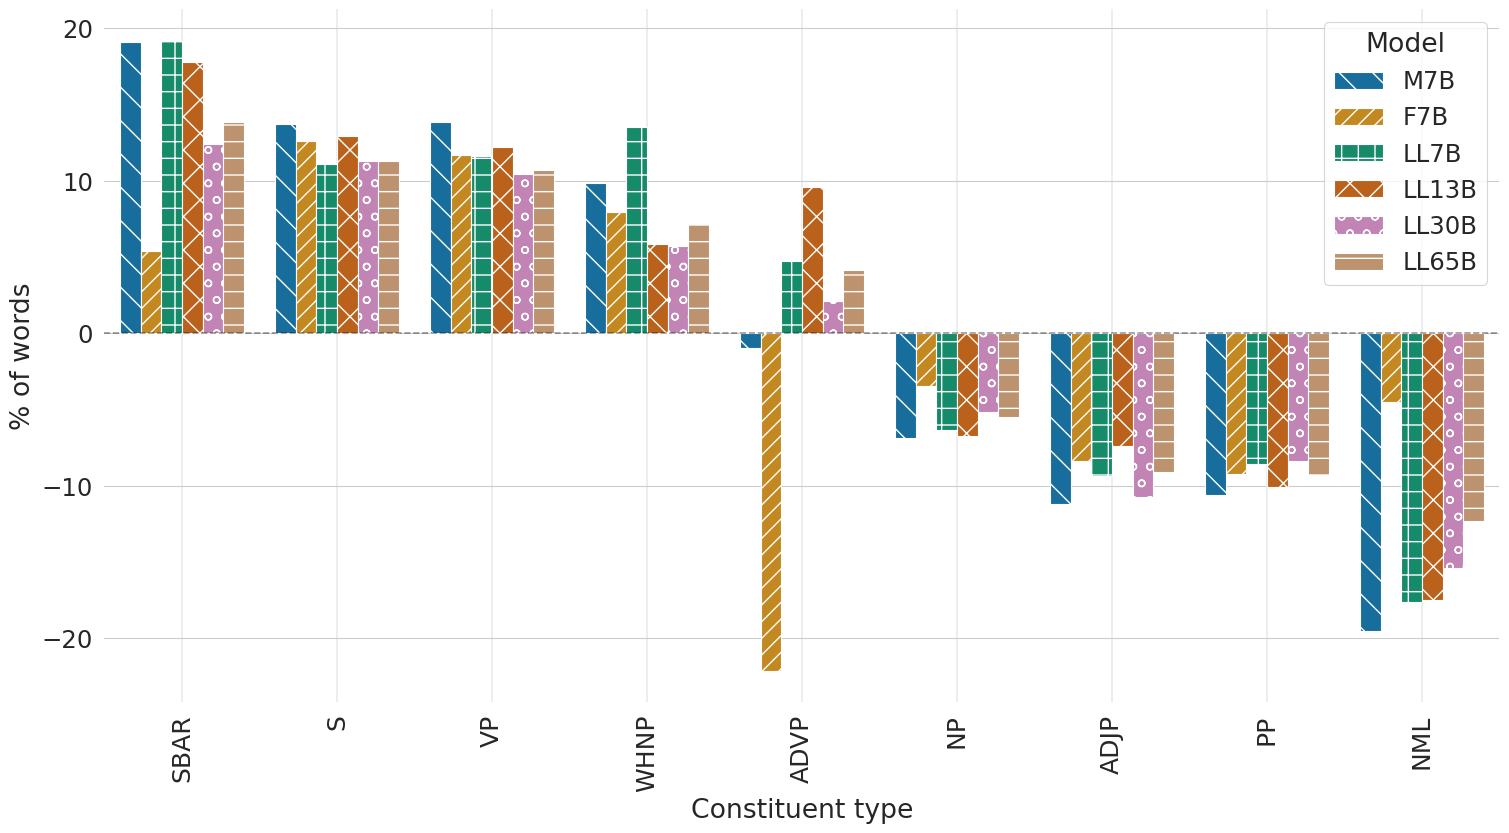

In [17]:
compare_df = relative_df.copy()

compare_df['LL7B'] = (compare_df['llama_7B']-compare_df['original'])*100
compare_df['LL13B'] = (compare_df['llama_13B']-compare_df['original'])*100
compare_df['LL30B'] = (compare_df['llama_30B']-compare_df['original'])*100
compare_df['LL65B'] = (compare_df['llama_65B']-compare_df['original'])*100
compare_df['M7B'] = (compare_df['mistral_7B']-compare_df['original'])*100
compare_df['F7B'] = (compare_df['falcon_7B']-compare_df['original'])*100
compare_df.drop(columns=['original'], inplace=True)
compare_df = compare_df.reset_index()

# sort by 65B
compare_df = compare_df.sort_values(by=['LL65B'], ascending=False)

compare_df = pd.melt(compare_df, id_vars=['symbol'], value_vars=['M7B', 'F7B', 'LL7B', 'LL13B', 'LL30B', 'LL65B'], var_name='lm', value_name='diff')
sns.set(context='paper', font_scale=2)

# create a custom color palette
palette = sns.color_palette("colorblind", 7)

# set white background
# create a new figure with a larger size
plt.figure(figsize=(18, 9))


sns.set_style("whitegrid")
barplot = sns.barplot(data=compare_df, x="symbol", y="diff", hue="lm", palette=palette)
sns.despine(top=True, right=True, left=True, bottom=True)

num_hatches = len(compare_df['symbol'].unique())

hatches = ['\\', '//', '+', 'x', 'o', '-']
model_hatches = {model: hatches[i % len(hatches)] for i, model in enumerate(compare_df['lm'].unique())}
for i, thisbar in enumerate(barplot.patches):
    model = compare_df['lm'].unique()[i // num_hatches]
    thisbar.set_hatch(model_hatches[model])

plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.8, axis='x')
plt.legend(title='Model')
plt.ylabel('% of words')
plt.xlabel('Constituent type')
plt.tick_params(axis='x', labelsize=18)

plt.xticks(rotation=90)

# horizontal line
plt.axhline(y=0, color='black', linestyle='--', alpha=0.4)
plt.savefig('plots/non_terminal_symbol_distribution.png', dpi=300, bbox_inches='tight')

In [18]:
# count occurrences of each value of 'source' in percentage
df = df_dict['original']
columns = ['source', 'document_type', 'news_desk', 'section_name', 'type_of_material']
for column in columns:
#    # retain values over 1%
    df[column] = df[column].apply(lambda x: x if x in df[column].value_counts(normalize=True)[df[column].value_counts(normalize=True) > 0.01].index else 'other')
    print(df[column].value_counts(normalize=True) * 100)
    print('\n')

source
The New York Times    100.0
Name: proportion, dtype: float64


document_type
article       93.312033
multimedia     6.687967
Name: proportion, dtype: float64


news_desk
Foreign         11.538741
other            9.730593
Culture          7.740905
Business         6.978433
OpEd             6.934863
Washington       5.685862
Express          4.415075
Metro            4.335197
National         4.313412
Politics         3.928545
Games            3.572725
Styles           3.253213
NYTNow           2.723114
Obits            2.498003
BookReview       2.367294
                 2.272892
Dining           2.200276
Science          2.062305
Podcasts         2.062305
Weekend          2.040520
Learning         1.837194
Magazine         1.386973
RealEstate       1.350664
Well             1.307095
Climate          1.219955
Arts&Leisure     1.154600
Summary          1.089246
Name: proportion, dtype: float64


section_name
U.S.                    18.023382
World                   14.312686
Arts 

In [19]:
import plotly.express as px

sources = ['document_type', 'section_name', 'type_of_material']
def plot_treemap(df, category):
    # Calculate counts and percentages
    counts = df[category].value_counts()
    percentages = counts / counts.sum()
    
    # Reset index to convert the series to a DataFrame
    data = percentages.reset_index()
    data.columns = [category, 'percentage']
    
    # Add a column for the parent (which in this case will be empty, as we are only displaying one level)
    data['parent'] = ''

    # Create the Treemap
    fig = px.treemap(
        data,
        path=['parent', category],
        values='percentage',
        title=f'Treemap of {category}'
    )

    fig.update_traces(textinfo='label+percent parent')
    fig.write_image(f"plots/{category}.png")
    fig.show()

def plot_several_treemaps(df, categories: list):
    """
    Plot and save treemaps for several categories in the same plot, side by side
    """



df = df_dict['original']
plot_treemap(df, 'document_type')
plot_treemap(df, 'section_name')
plot_treemap(df, 'type_of_material')

# save plots to plots/


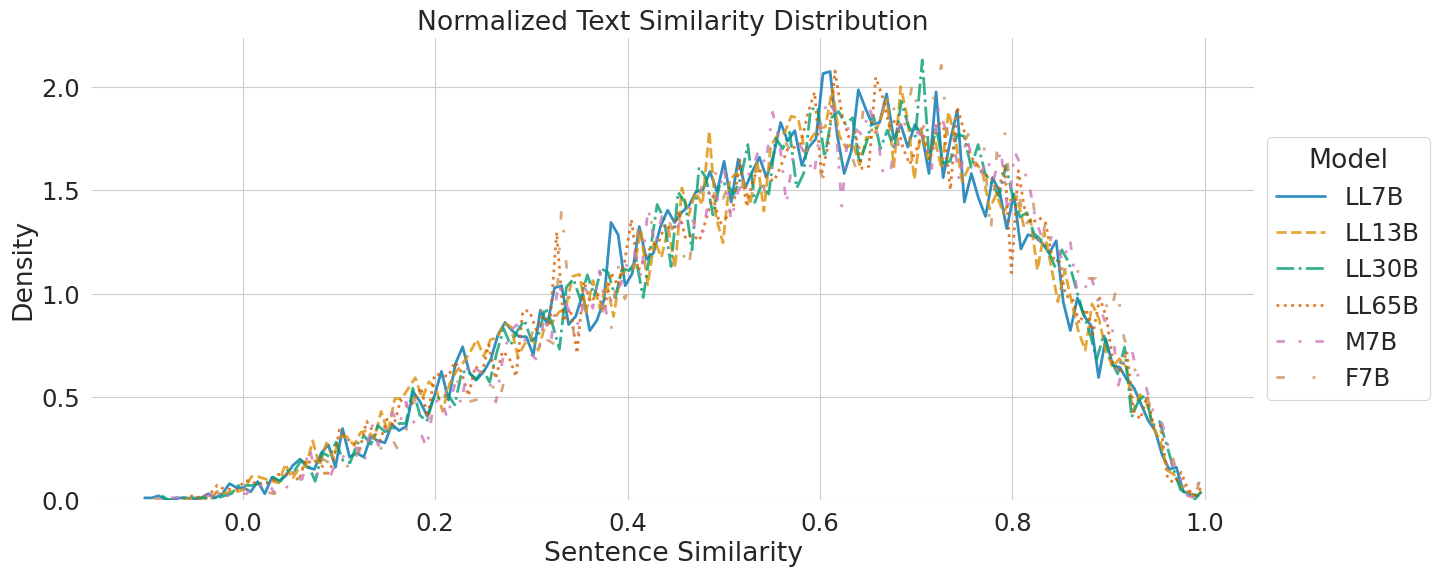

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

similarity_dict = {
    'llama_7B': [article['similarity'] for article in data_dict['llama_7B']],
    'llama_13B': [article['similarity'] for article in data_dict['llama_13B']],
    'llama_30B': [article['similarity'] for article in data_dict['llama_30B']],
    'llama_65B': [article['similarity'] for article in data_dict['llama_65B']],
    'mistral_7B': [article['similarity'] for article in data_dict['mistral_7B']],
    'falcon_7B': [article['similarity'] for article in data_dict['falcon_7B']],
}

palette = sns.color_palette("colorblind", 7)
alpha = 0.8
plt.figure(figsize=(15, 6))
labels = ['LL7B', 'LL13B', 'LL30B', 'LL65B', 'M7B', 'F7B']
linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (3, 10, 1, 10)), (0, (5, 10))]

# plot a histogram for each dataset in the same plot
for i, model in enumerate(similarity_dict):
    sns.histplot(
        data=similarity_dict[model],
        color=palette[i],
        label=labels[i],
        alpha=alpha,
        stat='density',
        element="poly",  # Use 'step' for clearer distinction in grayscale
        bins=150,
        fill=False,  # Consider setting this to True if using patterns
        linestyle=linestyles[i],  # Apply distinct linestyle
        linewidth=2,  # Increase linewidth for better visibility
    )

# remove the top and right spines
sns.despine(top=True, right=True, left=True, bottom=True)

plt.xlabel('Sentence Similarity')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Normalized Text Similarity Distribution')
plt.yticks((0, 0.5, 1, 1.5, 2))
plt.savefig('plots/normalized_sentence_similarity.png', bbox_inches='tight')


In [21]:
text_dict = {
    'headline': {article['_id']: f"{article['headline']['main']}" for article in data_dict['original']},
    'original': {article['_id']: f"{article['lead_paragraph']}" for article in data_dict['original']},
    'llama_7B': {article['_id']: f"{article['lead_paragraph']}" for article in data_dict['llama_7B']},
    'llama_13B': {article['_id']: f"{article['lead_paragraph']}" for article in data_dict['llama_13B']},
    'llama_30B': {article['_id']: f"{article['lead_paragraph']}" for article in data_dict['llama_30B']},
    'llama_65B': {article['_id']: f"{article['lead_paragraph']}" for article in data_dict['llama_65B']},
    'mistral_7B': {article['_id']: f"{article['lead_paragraph']}" for article in data_dict['mistral_7B']},
    'falcon_7B': {article['_id']: f"{article['lead_paragraph']}" for article in data_dict['falcon_7B']},
}

In [22]:
# print the value_counts for the emotions in each dataset
for key in data_dict.keys():
    print(key)
    #print(pd.DataFrame(data_dict[key])['emotion'].value_counts())
    # percentage
    # order by ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    order = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    print(round(pd.DataFrame(data_dict[key])['emotion'].sort_values().value_counts(normalize=True)[order] * 100, 2))
    print()

original
emotion
anger        8.69
disgust     10.58
fear        15.10
joy          6.39
neutral     46.88
sadness      9.62
surprise     2.73
Name: proportion, dtype: float64

llama_7B
emotion
anger        8.71
disgust      8.76
fear         9.84
joy          9.50
neutral     49.63
sadness     10.57
surprise     2.99
Name: proportion, dtype: float64

llama_13B
emotion
anger        8.55
disgust      8.76
fear         9.49
joy          9.27
neutral     49.95
sadness     10.70
surprise     3.27
Name: proportion, dtype: float64

llama_30B
emotion
anger        8.77
disgust      9.51
fear         9.79
joy          8.85
neutral     49.12
sadness     10.66
surprise     3.30
Name: proportion, dtype: float64

llama_65B
emotion
anger        8.64
disgust      9.30
fear        10.67
joy          9.06
neutral     48.99
sadness     10.09
surprise     3.25
Name: proportion, dtype: float64

mistral_7B
emotion
anger        9.02
disgust      9.00
fear        10.09
joy          8.05
neutral     50.45
sad

In [23]:
# create a list of dictionaries with the desired columns
data = []
for key in data_dict.keys():
    total_count = pd.DataFrame(data_dict[key])['emotion'].count()
    for emotion, count in pd.DataFrame(data_dict[key])['emotion'].value_counts().items():
        data.append({'key': key, 'emotion': emotion, 'count': count/total_count*100})

emotion     anger  disgust   fear   joy  neutral  sadness  surprise
key                                                                
falcon_7B    7.87     9.67   9.60  9.67    50.16    10.45      2.59
llama_13B    8.55     8.76   9.49  9.27    49.95    10.70      3.27
llama_30B    8.77     9.51   9.79  8.85    49.12    10.66      3.30
llama_65B    8.64     9.30  10.67  9.06    48.99    10.09      3.25
llama_7B     8.71     8.76   9.84  9.50    49.63    10.57      2.99
mistral_7B   9.02     9.00  10.09  8.05    50.45    10.54      2.86
original     8.69    10.58  15.10  6.39    46.88     9.62      2.73

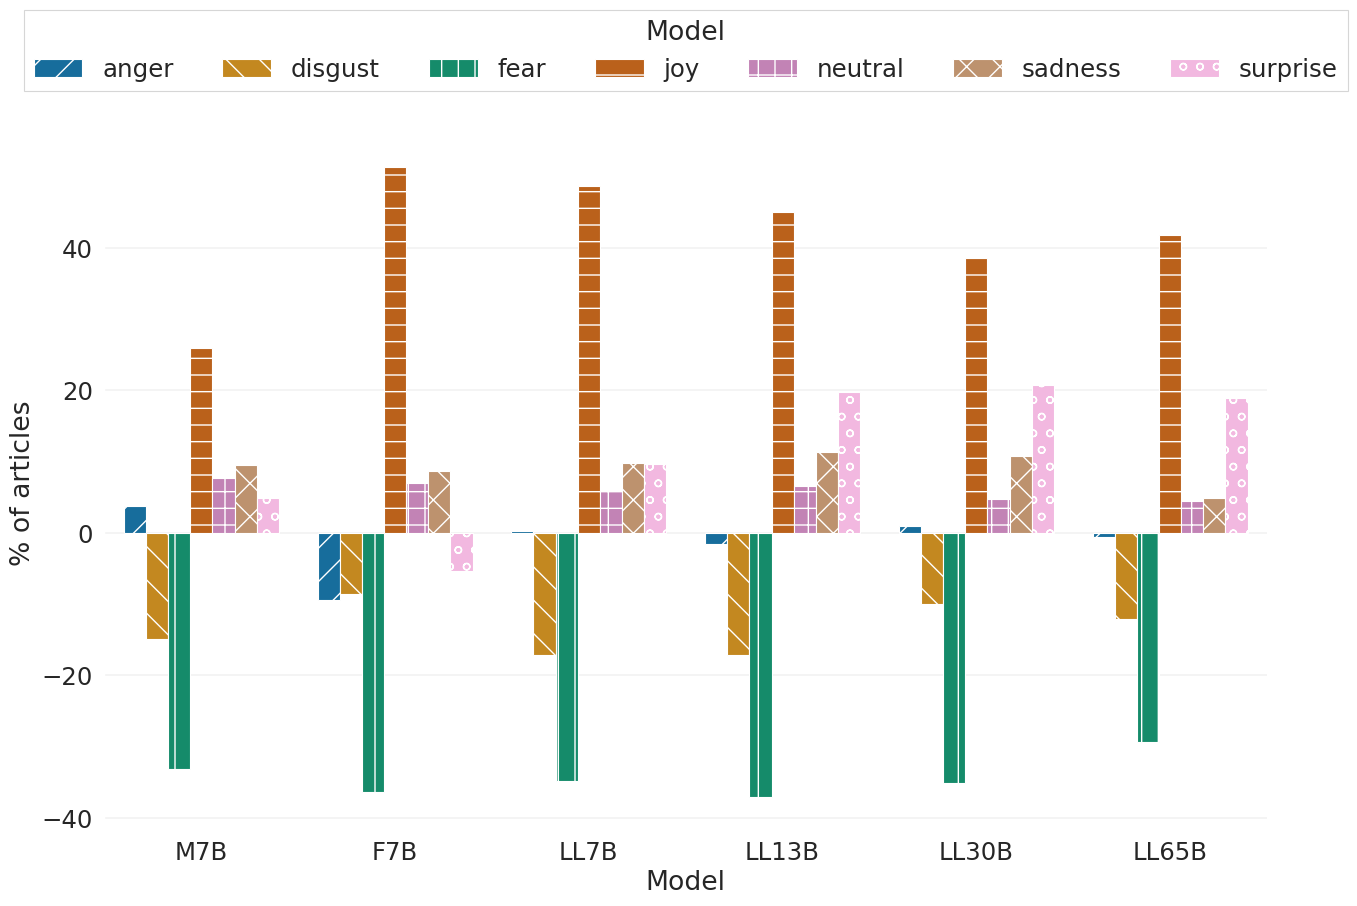

In [24]:
# calculate the count values for each emotion in the "original" key
import pandas as pd
sns.set_style("whitegrid")
original_counts = {}
df = pd.DataFrame(data)


df = df.pivot(index='emotion', columns='key', values='count')
df['llama_7B'] = (df['llama_7B']/df['original'] - 1) * 100
df['llama_13B'] = (df['llama_13B']/df['original'] - 1) * 100
df['llama_30B'] = (df['llama_30B']/df['original'] - 1) * 100
df['llama_65B'] = (df['llama_65B']/df['original'] - 1) * 100
df['mistral_7B'] = (df['mistral_7B']/df['original'] - 1) * 100
df['falcon_7B'] = (df['falcon_7B']/df['original'] - 1) * 100

df.drop('original', axis=1, inplace=True)
# drop emotions as error
#df.drop('error', axis=0, inplace=True)
df = df.reset_index()
df = pd.melt(df, id_vars=['emotion'], value_vars=['mistral_7B', 'falcon_7B', 'llama_7B', 'llama_13B', 'llama_30B', 'llama_65B', ])
# sort values by neutral, fear, joy, disgust, sadness, anger, surprise
#df = df.sort_values(by=['emotion'], key=lambda x: x.map({'neutral': 0, 'fear': 1, 'joy': 2, 'disgust': 3, 'sadness': 4, 'anger': 5, 'surprise': 6}))

sns.set(context='paper', font_scale=2)

# create a custom color palette
palette = sns.color_palette("colorblind", 7)
# set white background
# create a new figure with a larger size
plt.figure(figsize=(15, 9))


barplot = sns.barplot(x="key", y="value", hue="emotion", data=df, palette=palette, orient='v')
# Define hatch patterns
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.']

# Create a dictionary mapping each emotion to a hatch pattern
emotion_hatches = {emotion: hatches[i % len(hatches)] for i, emotion in enumerate(df['emotion'].unique())}

# Get the number of different keys (x-axis categories)
num_keys = len(df['key'].unique())

# Set hatch pattern for each bar
for i, thisbar in enumerate(barplot.patches):
    # Get the emotion for this bar
    emotion = df['emotion'].unique()[i // num_keys]
    
    # Set the hatch pattern for this bar
    thisbar.set_hatch(emotion_hatches[emotion])


# move the legend outside of the plot
legend = plt.legend(title='Model', loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=7, fancybox=False, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')
# set the y-axis label to '% of articles'
plt.ylabel('% of articles')
plt.xlabel('Model')

# set the style to whitegrid
sns.set_style("whitegrid")

# remove the top and right spines
sns.despine(top=True, right=True)

# Set the axes background color
plt.gca().set_facecolor('white')

# Or, set the figure background color
plt.gcf().set_facecolor('white')


# set the grid color to gray
plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')


# change xticks to ['M7B', 'F7B', 'LL7B', 'LL13B', 'LL30B', 'LL65B']
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['M7B', 'F7B', 'LL7B', 'LL13B', 'LL30B', 'LL65B'])
# rotate the x-axis labels

# save the figure
plt.savefig('plots/rel_emotion_dist.png', dpi=300, bbox_inches='tight')
round(pd.DataFrame(data).pivot(index='key', columns='emotion', values='count'), 2)


In [25]:
round(pd.DataFrame(data).pivot(index='key', columns='emotion', values='count'), 2).to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\nemotion & anger & disgust & fear & joy & neutral & sadness & surprise \\\\\nkey &  &  &  &  &  &  &  \\\\\n\\midrule\nfalcon_7B & 7.870000 & 9.670000 & 9.600000 & 9.670000 & 50.160000 & 10.450000 & 2.590000 \\\\\nllama_13B & 8.550000 & 8.760000 & 9.490000 & 9.270000 & 49.950000 & 10.700000 & 3.270000 \\\\\nllama_30B & 8.770000 & 9.510000 & 9.790000 & 8.850000 & 49.120000 & 10.660000 & 3.300000 \\\\\nllama_65B & 8.640000 & 9.300000 & 10.670000 & 9.060000 & 48.990000 & 10.090000 & 3.250000 \\\\\nllama_7B & 8.710000 & 8.760000 & 9.840000 & 9.500000 & 49.630000 & 10.570000 & 2.990000 \\\\\nmistral_7B & 9.020000 & 9.000000 & 10.090000 & 8.050000 & 50.450000 & 10.540000 & 2.860000 \\\\\noriginal & 8.690000 & 10.580000 & 15.100000 & 6.390000 & 46.880000 & 9.620000 & 2.730000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [26]:
sentences_dict = {
    'original': [sentence for article in data_dict['original'] for sentence in article['parsed']],
    'llama_7B': [sentence for article in data_dict['llama_7B'] for sentence in article['parsed']],
    'llama_13B': [sentence for article in data_dict['llama_13B'] for sentence in article['parsed']],
    'llama_30B': [sentence for article in data_dict['llama_30B'] for sentence in article['parsed']],
    'llama_65B': [sentence for article in data_dict['llama_65B'] for sentence in article['parsed']],
    'mistral_7B': [sentence for article in data_dict['mistral_7B'] for sentence in article['parsed']],
    'falcon_7B': [sentence for article in data_dict['falcon_7B'] for sentence in article['parsed']],
}

length_dict = {
    'original': [len(sentence) for sentence in sentences_dict['original'] if len(sentence) < 100], # only a handful of sentences over 100 (less)
    'llama_7B': [len(sentence) for sentence in sentences_dict['llama_7B'] if len(sentence) < 100],
    'llama_13B': [len(sentence) for sentence in sentences_dict['llama_13B'] if len(sentence) < 100],
    'llama_30B': [len(sentence) for sentence in sentences_dict['llama_30B'] if len(sentence) < 100],
    'llama_65B': [len(sentence) for sentence in sentences_dict['llama_65B'] if len(sentence) < 100],
    'mistral_7B': [len(sentence) for sentence in sentences_dict['mistral_7B'] if len(sentence) < 100],
    'falcon_7B': [len(sentence) for sentence in sentences_dict['falcon_7B'] if len(sentence) < 100],
}

data = [
    length_dict['original'],
    length_dict['llama_7B'],
    length_dict['llama_13B'],
    length_dict['llama_30B'],
    length_dict['llama_65B'],
    length_dict['mistral_7B'],
    length_dict['falcon_7B'],
]


In [27]:
# omega values
import lal


def calculate_omega(parsed_sentence):
    """
    Calculate Omega value for a given sentence
    """
    head_tree = [token['head'] for token in parsed_sentence]
    rt = lal.graphs.from_head_vector_to_rooted_tree(head_tree)
    D = lal.linarr.sum_edge_lengths(rt)
    Dmin, arr_unc = lal.linarr.min_sum_edge_lengths(rt)
    Drla = (1/3)*(len(head_tree)**2-1)
    try:
        Omega = (Drla-D)/(Drla-Dmin)
    except ZeroDivisionError:
        Omega = 0

    return Omega

try:
    print(omega_dict)
except NameError:
    omega_dict = {
        'original': [calculate_omega(sentence) for sentence in tqdm(sentences_dict['original'])],
        'llama_7B': [calculate_omega(sentence) for sentence in tqdm(sentences_dict['llama_7B'])],
        'llama_13B': [calculate_omega(sentence) for sentence in tqdm(sentences_dict['llama_13B'])],
        'llama_30B': [calculate_omega(sentence) for sentence in tqdm(sentences_dict['llama_30B'])],
        'llama_65B': [calculate_omega(sentence) for sentence in tqdm(sentences_dict['llama_65B'])],
        'mistral_7B': [calculate_omega(sentence) for sentence in tqdm(sentences_dict['mistral_7B'])],
        'falcon_7B': [calculate_omega(sentence) for sentence in tqdm(sentences_dict['falcon_7B'])],
    }

100%|██████████| 27865/27865 [00:04<00:00, 6387.33it/s]


In [28]:
# print mean and std for omega
for key in omega_dict:
    print(key)
    print(f"Mean: {round(np.mean(omega_dict[key]), 2)}")
    print(f"Standard deviation: {round(np.std(omega_dict[key]), 2)}")
    print(f"Number of sentences: {len(omega_dict[key])}")
    print('-----------------------------------')

original
Mean: 0.73
Standard deviation: 0.25
Number of sentences: 26372
-----------------------------------
llama_7B
Mean: 0.73
Standard deviation: 0.22
Number of sentences: 37973
-----------------------------------
llama_13B
Mean: 0.72
Standard deviation: 0.24
Number of sentences: 37956
-----------------------------------
llama_30B
Mean: 0.71
Standard deviation: 0.24
Number of sentences: 37650
-----------------------------------
llama_65B
Mean: 0.72
Standard deviation: 0.23
Number of sentences: 38202
-----------------------------------
mistral_7B
Mean: 0.72
Standard deviation: 0.23
Number of sentences: 35243
-----------------------------------
falcon_7B
Mean: 0.72
Standard deviation: 0.22
Number of sentences: 27865
-----------------------------------


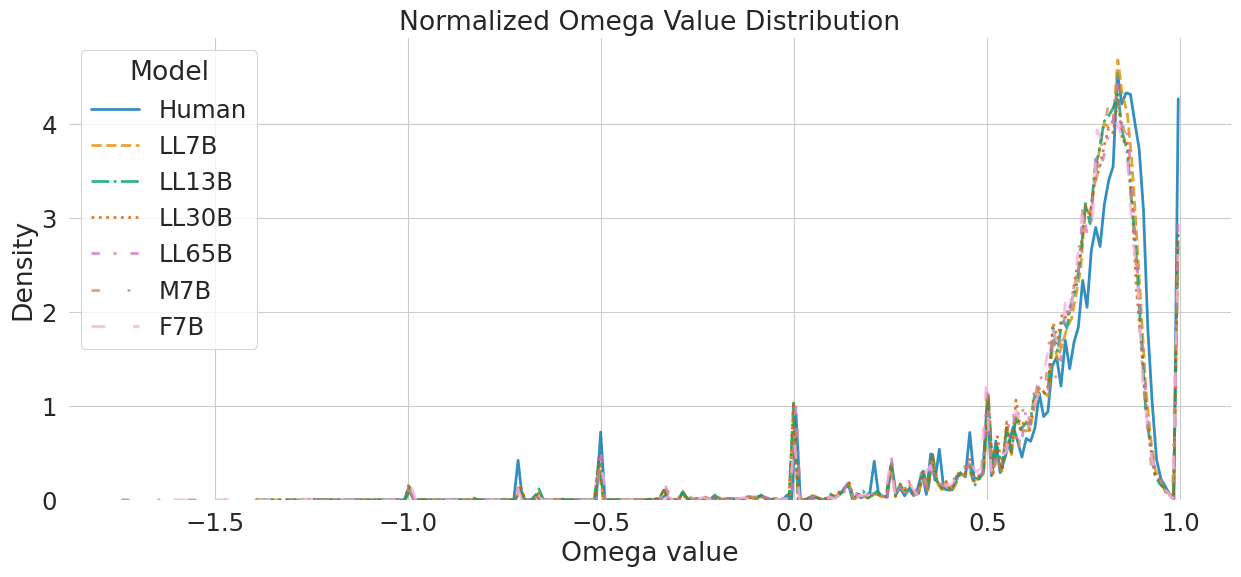

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("colorblind", 7)
alpha = 0.8
plt.figure(figsize=(15, 6))
labels = ['Human', 'LL7B', 'LL13B', 'LL30B', 'LL65B', 'M7B', 'F7B']
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 10, 1, 10))]


# plot a line plot for each dataset in the same plot
for i, model in enumerate(omega_dict):
    # percentage
    sns.histplot(
        data=omega_dict[model], 
        color=palette[i], 
        label=labels[i],
        alpha=alpha,
        bins=200, 
        stat='density', 
        element="poly", 
        fill=False,
        linestyle=linestyles[i],  # Apply distinct linestyle
        linewidth=2,  # Increase linewidth for better visibility
    )



# remove the top and right spines
sns.despine(top=True, right=True, left=True, bottom=True)

# set the x-axis label to 'Omega value'
plt.xlabel('Omega value')

# add a legend to the top right corner of the plot
plt.legend(title='Model')

# set the title of the plot
plt.title('Normalized Omega Value Distribution')

# save the plot as a figure
plt.savefig('plots/normalized_omega_value_lineplot.png', bbox_inches='tight')

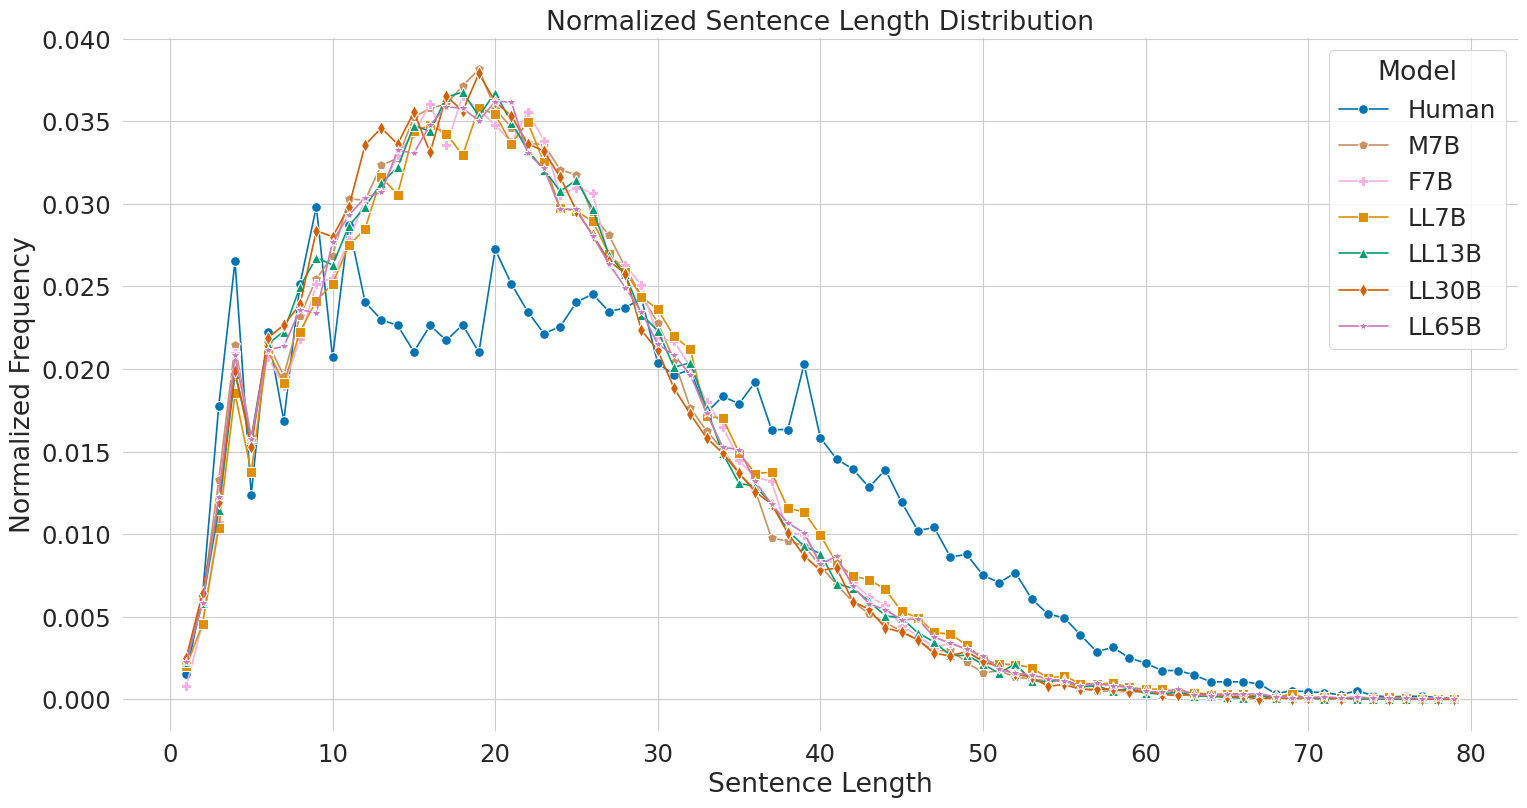

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

length_dict = {
    'original': [len(sentence) for sentence in sentences_dict['original'] if len(sentence) < 80], # only a handful of sentences over 100 (less)
    'llama_7B': [len(sentence) for sentence in sentences_dict['llama_7B'] if len(sentence) < 80],
    'llama_13B': [len(sentence) for sentence in sentences_dict['llama_13B'] if len(sentence) < 80],
    'llama_30B': [len(sentence) for sentence in sentences_dict['llama_30B'] if len(sentence) < 80],
    'llama_65B': [len(sentence) for sentence in sentences_dict['llama_65B'] if len(sentence) < 80],
    'mistral_7B': [len(sentence) for sentence in sentences_dict['mistral_7B'] if len(sentence) < 80],
    'falcon_7B': [len(sentence) for sentence in sentences_dict['falcon_7B'] if len(sentence) < 80],
}

# create a dictionary of value counts for each model
value_counts_dict = {model: pd.Series(length_dict[model]).value_counts(normalize=True) for model in length_dict.keys()}

# create a DataFrame from the dictionary of value counts
value_counts_df = pd.DataFrame(value_counts_dict)

# fill missing values with 0
value_counts_df = value_counts_df.fillna(0)

# sort the DataFrame by the index (sentence length)
value_counts_df = value_counts_df.sort_index()

# bigger plot
plt.figure(figsize=(18, 9))

# create a color palette
palette = sns.color_palette("colorblind", len(length_dict))
alpha = 0.7

# plot a line plot with markers for each dataset in the same plot
sns.lineplot(data=value_counts_df['original'], color=palette[0], label='Human', marker='o', markersize=7)
sns.lineplot(data=value_counts_df['mistral_7B'], color=palette[5], label='M7B', marker='p', markersize=7)
sns.lineplot(data=value_counts_df['falcon_7B'], color=palette[6], label='F7B', marker='P', markersize=7)
sns.lineplot(data=value_counts_df['llama_7B'], color=palette[1], label='LL7B', marker='s', markersize=7)
sns.lineplot(data=value_counts_df['llama_13B'], color=palette[2], label='LL13B', marker='^', markersize=7)
sns.lineplot(data=value_counts_df['llama_30B'], color=palette[3], label='LL30B', marker='d', markersize=7)
sns.lineplot(data=value_counts_df['llama_65B'], color=palette[4], label='LL65B', marker='*', markersize=7)


# remove the top and right spines
sns.despine(top=True, right=True, left=True, bottom=True)

# set the x-axis label to 'Sentence Length'
plt.xlabel('Sentence Length')

# add a legend to the top right corner of the plot
plt.legend(title='Model', loc='upper right')

# set the y-axis label to 'Normalized Frequency'
plt.ylabel('Normalized Frequency')

# set the title of the plot
plt.title('Normalized Sentence Length Distribution')

plt.savefig('plots/normalized_sentence_length_distribution.png', dpi=300, bbox_inches='tight')

In [31]:
# return arc length (with directions)
def arc_length_from_sentences(sentences_dict, lower_limit= 10, upper_limit=20):
    arc_length_dic = {}
    for lm in sentences_dict.keys():
        arc_length_dic[lm] = {}
        right_arcs = []
        left_arcs = []
        all_arcs = [] # absolute value
        for sentence in sentences_dict[lm]:
            if lower_limit > len(sentence) > upper_limit:
                continue
            for token in sentence:
                if token['head'] == 0:
                    continue
                if token['head'] > token['id']:
                    right_arcs.append(token['head'] - token['id'])
                    
                elif token['head'] < token['id']:
                    left_arcs.append(token['id'] - token['head'])
                
                if -25 < (token['head'] - token['id']) < 25:
                    all_arcs.append(token['head'] - token['id'])
        
        arc_length_dic[lm]['right_arcs'] = right_arcs
        arc_length_dic[lm]['left_arcs'] = left_arcs
        arc_length_dic[lm]['all_arcs'] = all_arcs

    return arc_length_dic

arc_length_dict = arc_length_from_sentences(sentences_dict, 30, 40)


In [32]:
length_dict = create_length_dict(sentences_dict, 50,10)
df = pd.DataFrame(columns=['lm', '% l', '% r', 'avg_len', 'avg_r_len', 'avg_l_len', 'std_len', 'std_r_len', 'std_l_len', 'n_sentences', 'lenghts'])

for length in length_dict.keys():
    l_df = stats_df(length_dict[length])
    l_df['lenghts'] = length
    df = pd.concat([df, l_df], ignore_index=False)

df = df.set_index(['lenghts', 'lm'], inplace=False)
round(df, 2)

% l    % r  avg_len  avg_r_len  avg_l_len  std_len   
lenghts lm                                                                 
1_10    original    49.40  50.60     2.37       2.89       1.84     1.67  \
        llama_7B    50.68  49.32     2.37       2.95       1.81     1.65   
        llama_13B   50.42  49.58     2.37       2.94       1.81     1.65   
        llama_30B   49.97  50.03     2.37       2.92       1.81     1.65   
        llama_65B   50.23  49.77     2.36       2.91       1.81     1.64   
        mistral_7B  50.94  49.06     2.37       2.93       1.83     1.65   
        falcon_7B   52.08  47.92     2.39       2.99       1.84     1.62   
11_20   original    58.36  41.64     3.19       4.62       2.17     3.12   
        llama_7B    59.74  40.26     3.11       4.63       2.09     3.03   
        llama_13B   59.69  40.31     3.12       4.63       2.11     3.03   
        llama_30B   59.62  40.38     3.12       4.63       2.11     3.03   
        llama_65B   59.43  40.57     3.13       4.63       2.10     3.04   
        mistral_7B  59.76  40.24     3.12       4.63       2.10     3.03   
        falcon_7B   61.41  38.59     3.20       4.79       2.19     3.06   
21_30   original    60.40  39.60     3.64       5.52       2.41     4.42   
        llama_7B    60.87  39.13     3.51       5.47       2.25     4.26   
        llama_13B   60.86  39.14     3.53       5.49       2.27     4.27   
        llama_30B   60.71  39.29     3.53       5.48       2.27     4.26   
        llama_65B   60.47  39.53     3.53       5.47       2.26     4.28   
        mistral_7B  61.00  39.00     3.53       5.50       2.26     4.28   
        falcon_7B   62.51  37.49     3.62       5.70       2.38     4.32   
31_40   original    60.84  39.16     3.90       6.07       2.50     5.49   
        llama_7B    60.79  39.21     3.78       5.98       2.35     5.34   
        llama_13B   60.51  39.49     3.79       5.96       2.38     5.33   
        llama_30B   60.35  39.65     3.81       5.95       2.40     5.33   
        llama_65B   60.35  39.65     3.79       5.95       2.37     5.31   
        mistral_7B  60.48  39.52     3.79       5.95       2.38     5.35   
        falcon_7B   61.98  38.02     3.89       6.11       2.52     5.35   
41_     original    60.48  39.52     4.01       6.28       2.53     6.20   
        llama_7B    59.83  40.17     3.97       6.25       2.44     6.24   
        llama_13B   60.47  39.53     3.99       6.29       2.48     6.23   
        llama_30B   60.21  39.79     3.98       6.24       2.49     6.21   
        llama_65B   60.08  39.92     3.95       6.22       2.45     6.16   
        mistral_7B  60.09  39.91     3.95       6.23       2.44     6.24   
        falcon_7B   61.77  38.23     4.04       6.43       2.56     6.18   

                    std_r_len  std_l_len n_sentences  
lenghts lm                                            
1_10    original         1.90       1.17        4719  
        llama_7B         1.88       1.14        6114  
        llama_13B        1.88       1.14        6711  
        llama_30B        1.89       1.14        6808  
        llama_65B        1.87       1.15        6652  
        mistral_7B       1.88       1.16        6190  
        falcon_7B        1.84       1.15        4596  
11_20   original         3.87       1.86        6179  
        llama_7B         3.81       1.72       12361  
        llama_13B        3.81       1.75       12762  
        llama_30B        3.80       1.76       13039  
        llama_65B        3.81       1.75       12767  
        mistral_7B       3.80       1.74       12113  
        falcon_7B        3.85       1.83        9265  
21_30   original         5.71       2.68        6153  
        llama_7B         5.64       2.30       11014  
        llama_13B        5.64       2.34       11017  
        llama_30B        5.61       2.34       10810  
        llama_65B        5.63       2.35       10884  
        mistral_7B       5.65       2.33       10449  

In [33]:
# print round(df, 2).to_latex()
dep_len_table = round(df, 2).to_latex().replace('0000', '').replace('llama_', '').replace('original', 'Human')

dic = {
    '7B': 'LL7B',
    '13B': 'LL13B',
    '30B': 'LL30B',
    '65B': 'LL65B',
    'mistral_7B': 'M7B',
    'falcon_7B': 'F7B',
}

dep_len_table = dep_len_table.replace('7B', 'LL7B').replace('13B', 'LL13B').replace('30B', 'LL30B').replace('65B', 'LL65B').replace('mistral_7B', 'M7B').replace('falcon_7B', 'F7B')
print(dep_len_table)

\begin{tabular}{llrrrrrrrrl}
\toprule
 &  & % l & % r & avg_len & avg_r_len & avg_l_len & std_len & std_r_len & std_l_len & n_sentences \\
lenghts & lm &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{1_10} & Human & 49.40 & 50.60 & 2.37 & 2.89 & 1.84 & 1.67 & 1.90 & 1.17 & 4719 \\
 & LL7B & 50.68 & 49.32 & 2.37 & 2.95 & 1.81 & 1.65 & 1.88 & 1.14 & 6114 \\
 & LL13B & 50.42 & 49.58 & 2.37 & 2.94 & 1.81 & 1.65 & 1.88 & 1.14 & 6711 \\
 & LL30B & 49.97 & 50.03 & 2.37 & 2.92 & 1.81 & 1.65 & 1.89 & 1.14 & 6808 \\
 & LL65B & 50.23 & 49.77 & 2.36 & 2.91 & 1.81 & 1.64 & 1.87 & 1.15 & 6652 \\
 & mistral_LL7B & 50.94 & 49.06 & 2.37 & 2.93 & 1.83 & 1.65 & 1.88 & 1.16 & 6190 \\
 & falcon_LL7B & 52.08 & 47.92 & 2.39 & 2.99 & 1.84 & 1.62 & 1.84 & 1.15 & 4596 \\
\cline{1-11}
\multirow[t]{7}{*}{11_20} & Human & 58.36 & 41.64 & 3.19 & 4.62 & 2.17 & 3.12 & 3.87 & 1.86 & 6179 \\
 & LL7B & 59.74 & 40.26 & 3.11 & 4.63 & 2.09 & 3.03 & 3.81 & 1.72 & 12361 \\
 & LL13B & 59.69 & 40.31 & 3.12 & 4.63 & 2

In [34]:
# Gender analysis
def return_parses(data_dict, by='token'):
    """
    Return a dictionary with the parses for each language model at token or sentence level
    """
    parses_dict = {}
    for lm in data_dict.keys():
        parses_dict[lm] = []
        for article in data_dict[lm]:
            if 'parsed' in article.keys():
                for sentence in article['parsed']:
                    if by == 'token':
                        parses_dict[lm].extend(sentence)
                    elif by == 'sentence':
                        parses_dict[lm].append(sentence)

    return parses_dict


In [35]:
# type-token ratio
def type_token_ratio(parses_dict):
    """
    Return a dictionary with the type-token ratio for each language model
    """
    ttr_dict = {}
    for lm in parses_dict.keys():
        tokens = [token['text'] for token in parses_dict[lm]]
        ttr_dict[lm] = len(set(tokens))/len(tokens)
        print('LM: ', lm, 'Tokens: ', len(tokens), 'Unique tokens: ', len(set(tokens)), 'TTR: ' , round(ttr_dict[lm], 3))

    return ttr_dict

parses_dict = return_parses(data_dict, by='token')
ttr_dict = type_token_ratio(parses_dict)


LM:  original Tokens:  676591 Unique tokens:  39058 TTR:  0.058
LM:  llama_7B Tokens:  843087 Unique tokens:  37553 TTR:  0.045
LM:  llama_13B Tokens:  809551 Unique tokens:  37091 TTR:  0.046
LM:  llama_30B Tokens:  790059 Unique tokens:  38390 TTR:  0.049
LM:  llama_65B Tokens:  824739 Unique tokens:  39881 TTR:  0.048
LM:  mistral_7B Tokens:  741489 Unique tokens:  34399 TTR:  0.046
LM:  falcon_7B Tokens:  606020 Unique tokens:  29262 TTR:  0.048


In [36]:
def create_sentence_stats_df(sentences_dict):
    # create a list of dictionaries with the desired columns
    data = []
    for key in sentences_dict.keys():
        sentence_lengths = [len(sentence) for sentence in sentences_dict[key]]
        data.append({'key': key, 'num_sentences': len(sentences_dict[key]), 'avg_sentence_length': np.mean(sentence_lengths), 'std_sentence_length': np.std(sentence_lengths)})
    
    # create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    
    return df


sentences_dict = return_parses(data_dict, 'sentence')
df = create_sentence_stats_df(sentences_dict)

round(df, 2) # todo: numero de palabras por modelo (unicas)

key  num_sentences  avg_sentence_length  std_sentence_length
0    original          26372                25.66                15.01
1    llama_7B          37973                22.20                11.70
2   llama_13B          37956                21.33                11.28
3   llama_30B          37650                20.98                11.20
4   llama_65B          38202                21.59                11.63
5  mistral_7B          35243                21.04                10.95
6   falcon_7B          27865                21.75                11.44

In [37]:
parses_dict = return_parses(data_dict, 'token')

for lm in parses_dict.keys():
    female_count = 0
    male_count = 0
    total_words = 0
    for token in parses_dict[lm]:
        if 'feats' in token.keys():
            if 'Gender=Fem' in token['feats'].split('|'):
                female_count += 1
            elif 'Gender=Masc' in token['feats'].split('|'):
                male_count += 1
    
    # print ratio
    print(lm)
    print("M-F ratio: ", round(male_count/female_count, 4))

original
M-F ratio:  1.714
llama_7B
M-F ratio:  1.857
llama_13B
M-F ratio:  1.8853
llama_30B
M-F ratio:  1.8713
llama_65B
M-F ratio:  1.8824
mistral_7B
M-F ratio:  1.7446
falcon_7B
M-F ratio:  1.6384


In [38]:
# xpos
parses_dict = return_parses(data_dict, 'token')

total_tokens = 0
xpos_dict = {}
for lm in parses_dict.keys():
    xpos_list = []
    for token in parses_dict[lm]:
        if 'xpos' in token.keys():
            xpos_list.append(token['xpos'])
    xpos_dict[lm] = pd.Series(xpos_list).value_counts()
    xpos_dict[lm] = xpos_dict[lm]*100/len(xpos_list)

# plot xpos
df = pd.DataFrame(columns=['lm', 'xpos', 'count'])
for lm in xpos_dict.keys():
    for xpos, count in xpos_dict[lm].items():
        df = pd.concat([df, pd.DataFrame({'lm': lm, 'xpos': xpos, 'count': count}, index=[0])], ignore_index=True)

df = df.pivot(index='xpos', columns='lm', values='count')

# order by original
df = df.sort_values(by='original', ascending=False)
# select only those bigger than 1%
df = df[df['original'] > 1]

# calculate relative to original
relative_df = df.copy()
relative_df['llama_7B'] = df['llama_7B']/df['original']
relative_df['llama_13B'] = df['llama_13B']/df['original']
relative_df['llama_30B'] = df['llama_30B']/df['original']
relative_df['llama_65B'] = df['llama_65B']/df['original']
relative_df['mistral_7B'] = df['mistral_7B']/df['original']
relative_df['falcon_7B'] = df['falcon_7B']/df['original']
relative_df['original'] = df['original']/df['original']
#relative_df = relative_df.drop(columns=['original'])

round(df, 2)

lm    falcon_7B  llama_13B  llama_30B  llama_65B  llama_7B  mistral_7B   
xpos                                                                     
NN        13.77      12.92      13.09      13.06     13.04       13.21  \
IN        11.42      12.12      12.07      12.05     12.25       12.05   
NNP        9.77       9.43       9.79       9.75      9.40        9.03   
DT        10.85       8.85       8.94       8.81      8.85        9.18   
JJ         5.53       5.60       5.56       5.60      5.68        5.54   
NNS        4.07       4.73       4.73       4.87      4.89        4.83   
,          4.74       4.02       4.22       4.18      3.97        4.07   
.          4.44       4.41       4.50       4.35      4.23        4.47   
VBD        2.95       3.25       3.36       3.32      3.22        3.18   
RB         2.44       3.42       3.11       3.20      3.25        3.08   
CC         2.52       2.70       2.61       2.67      2.68        2.72   
PRP        3.37       3.98       3.74       3.69      3.72        3.83   
VB         2.74       3.01       2.85       2.92      3.00        3.12   
VBN        2.58       2.54       2.52       2.54      2.63        2.54   
VBG        1.73       1.82       1.78       1.82      1.84        1.86   
VBZ        2.83       2.67       2.57       2.53      2.57        2.73   
CD         1.97       1.97       2.04       2.01      2.01        1.94   
PRP$       1.22       1.55       1.51       1.49      1.53        1.49   
TO         1.57       1.47       1.38       1.43      1.48        1.56   
VBP        1.62       1.71       1.63       1.62      1.67        1.72   

lm    original  
xpos            
NN       14.33  
IN       12.39  
NNP       9.87  
DT        9.09  
JJ        6.49  
NNS       5.48  
,         5.08  
.         3.76  
VBD       3.25  
RB        2.92  
CC        2.65  
PRP       2.50  
VB        2.48  
VBN       2.30  
VBG       1.97  
VBZ       1.83  
CD        1.76  
PRP$      1.45  
TO        1.24  
VBP       1.20

In [39]:
# deprel
parses_dict = return_parses(data_dict, 'token')

total_tokens = 0
deprel_dict = {}
for lm in parses_dict.keys():
    deprel_list = []
    for token in parses_dict[lm]:
        if 'deprel' in token.keys():
            deprel_list.append(token['deprel'])
    deprel_dict[lm] = pd.Series(deprel_list).value_counts()
    deprel_dict[lm] = deprel_dict[lm]*100/len(deprel_list)

# plot deprel
df = pd.DataFrame(columns=['lm', 'deprel', 'count'])
for lm in deprel_dict.keys():
    for deprel, count in deprel_dict[lm].items():
        df = pd.concat([df, pd.DataFrame({'lm': lm, 'deprel': deprel, 'count': count}, index=[0])], ignore_index=True)

df = df.pivot(index='deprel', columns='lm', values='count')

# order by deprel
df = df.sort_values(by='original', ascending=False)
# drop values under 1
df = df[df['original'] > 1]
# calculate relative to original
relative_df = df.copy()
relative_df['llama_7B'] = df['llama_7B']/df['original']
relative_df['llama_13B'] = df['llama_13B']/df['original']
relative_df['llama_30B'] = df['llama_30B']/df['original']
relative_df['llama_65B'] = df['llama_65B']/df['original']
relative_df['mistral_7B'] = df['mistral_7B']/df['original']
relative_df['falcon_7B'] = df['falcon_7B']/df['original']
relative_df['original'] = df['original']/df['original']

# order by original, 7B, 13B, 30B, 65B
df = df[['original',  'mistral_7B', 'falcon_7B', 'llama_7B', 'llama_13B', 'llama_30B', 'llama_65B']]
#print(round(relative_df, 2).to_latex().replace('0000', ''))
print(round(df, 2).to_latex().replace('0000', '').replace('llama_', 'LL').replace('original', 'Human').replace('falcon_', 'F').replace('mistral_', 'M'))

\begin{tabular}{lrrrrrrr}
\toprule
lm & Human & M7B & F7B & LL7B & LL13B & LL30B & LL65B \\
deprel &  &  &  &  &  &  &  \\
\midrule
punct & 11.88 & 10.92 & 12.15 & 10.78 & 10.91 & 11.44 & 11.23 \\
case & 11.69 & 10.81 & 10.75 & 10.98 & 10.76 & 10.89 & 10.85 \\
det & 8.88 & 8.81 & 10.59 & 8.45 & 8.43 & 8.56 & 8.43 \\
amod & 6.98 & 5.57 & 5.73 & 5.79 & 5.60 & 5.71 & 5.75 \\
nsubj & 6.09 & 7.20 & 6.89 & 7.00 & 7.21 & 7.11 & 7.02 \\
obl & 5.50 & 5.24 & 4.67 & 5.39 & 5.31 & 5.36 & 5.31 \\
nmod & 4.95 & 4.45 & 4.84 & 4.50 & 4.40 & 4.47 & 4.47 \\
compound & 4.87 & 4.04 & 4.46 & 4.20 & 4.13 & 4.27 & 4.33 \\
obj & 4.28 & 4.41 & 3.91 & 4.22 & 4.23 & 4.19 & 4.27 \\
root & 3.90 & 4.75 & 4.60 & 4.50 & 4.69 & 4.77 & 4.63 \\
advmod & 3.46 & 3.63 & 2.91 & 3.83 & 3.98 & 3.65 & 3.76 \\
conj & 3.07 & 2.80 & 2.71 & 2.83 & 2.79 & 2.73 & 2.83 \\
mark & 2.65 & 3.35 & 2.94 & 3.27 & 3.28 & 3.07 & 3.12 \\
cc & 2.63 & 2.73 & 2.54 & 2.72 & 2.73 & 2.63 & 2.69 \\
nmod:poss & 2.34 & 2.21 & 2.01 & 2.21 & 2.19 & 2.19 

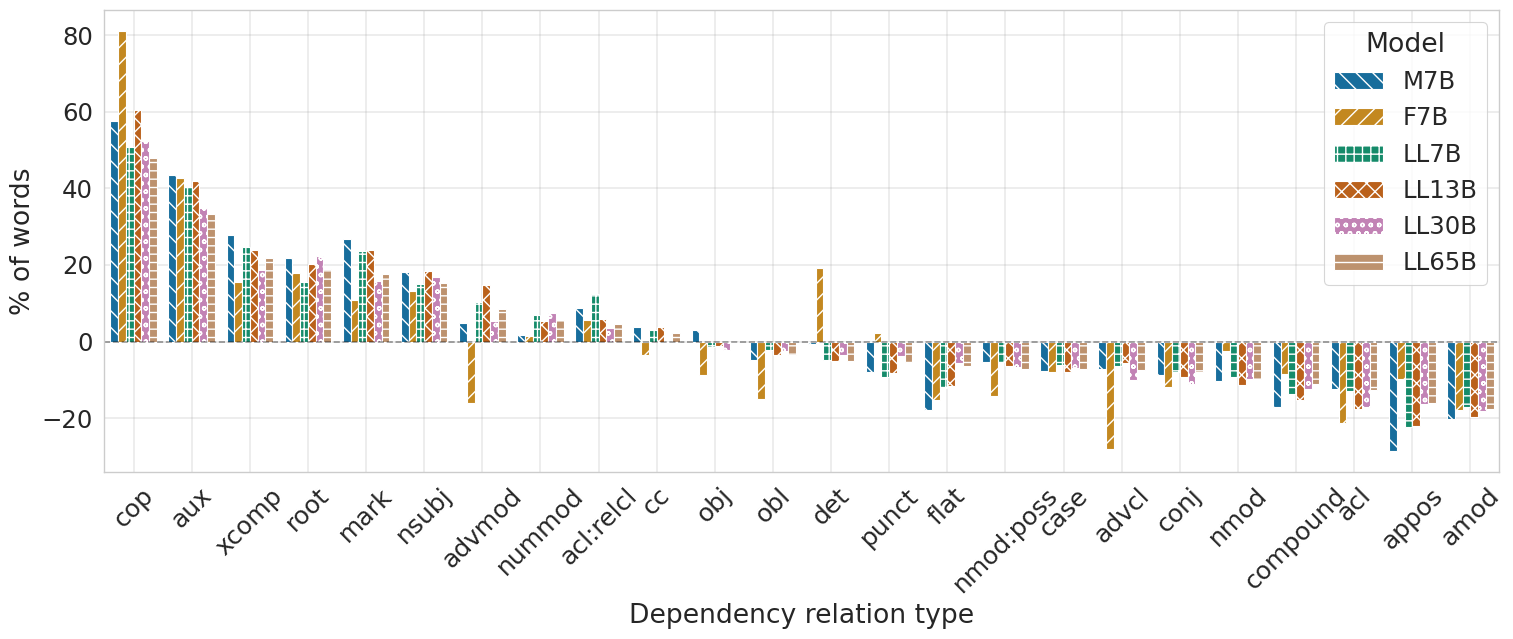

In [40]:
compare_df = relative_df.copy()

compare_df['LL7B'] = (compare_df['llama_7B']-compare_df['original'])*100
compare_df['LL13B'] = (compare_df['llama_13B']-compare_df['original'])*100
compare_df['LL30B'] = (compare_df['llama_30B']-compare_df['original'])*100
compare_df['LL65B'] = (compare_df['llama_65B']-compare_df['original'])*100
compare_df['M7B'] = (compare_df['mistral_7B']-compare_df['original'])*100
compare_df['F7B'] = (compare_df['falcon_7B']-compare_df['original'])*100
compare_df.drop(columns=['original'], inplace=True)
compare_df = compare_df.reset_index()

# sort by llama_65B
compare_df = compare_df.sort_values(by=['llama_65B'], ascending=False)

compare_df  = pd.melt(compare_df, id_vars=['deprel'], value_vars=['M7B', 'F7B', 'LL7B', 'LL13B', 'LL30B', 'LL65B'], var_name='lm', value_name='diff')
sns.set(context='paper', font_scale=2)

# create a custom color palette
palette = sns.color_palette("colorblind", 7)

# set white background
# create a new figure with a larger size
plt.figure(figsize=(18, 6))

sns.set_style("whitegrid")
sns.despine(top=True, right=True, left=True, bottom=True)

barplot = sns.barplot(data=compare_df, x="deprel", y="diff", hue="lm", palette=palette)
num_deprel = len(compare_df['deprel'].unique())

hatches = ['\\\\', '//', '++', 'xx', 'oo', '--']
model_hatches = {model: hatches[i % len(hatches)] for i, model in enumerate(compare_df['lm'].unique())}
for i, thisbar in enumerate(barplot.patches):
    model = compare_df['lm'].unique()[i // num_deprel]
    thisbar.set_hatch(model_hatches[model])

# scatterplot
plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.8, axis='both')
# change legend elements to Human, 7B, 13B, 30B, 65B
# take legend out of the plot
plt.legend(title='Model')#, loc='right center', bbox_to_anchor=(0.5, 1.5), ncol=6, fancybox=True, shadow=False)
# delete subax2 legend
plt.ylabel('% of words')
plt.xlabel('Dependency relation type')

plt.xticks(rotation=45)
plt.tick_params(axis='x', labelsize=18)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.4)

plt.savefig('plots/deprel_distribution.png', dpi=300, bbox_inches='tight')


In [41]:
# upos
total_tokens = 0
upos_dict = {}
for lm in parses_dict.keys():
    upos_list = []
    for token in parses_dict[lm]:
        if 'upos' in token.keys():
            upos_list.append(token['upos'])
    upos_dict[lm] = pd.Series(upos_list).value_counts()
    upos_dict[lm] = upos_dict[lm]*100/len(upos_list)

# plot upos
df = pd.DataFrame(columns=['lm', 'upos', 'count'])
for lm in upos_dict.keys():
    for upos, count in upos_dict[lm].items():
        df = pd.concat([df, pd.DataFrame({'lm': lm, 'upos': upos, 'count': count}, index=[0])], ignore_index=True)

df = df.pivot(index='upos', columns='lm', values='count')

# order by upos
df = df.sort_values(by='original', ascending=False)

# calculate relative to original
relative_df = df.copy()
relative_df['llama_7B'] = df['llama_7B']/df['original']
relative_df['llama_13B'] = df['llama_13B']/df['original']
relative_df['llama_30B'] = df['llama_30B']/df['original']
relative_df['llama_65B'] = df['llama_65B']/df['original']
relative_df['mistral_7B'] = df['mistral_7B']/df['original']
relative_df['falcon_7B'] = df['falcon_7B']/df['original']
relative_df['original'] = df['original']/df['original']

# order by original, 7B, 13B, 30B, 65B
df = df[['original',  'mistral_7B', 'falcon_7B', 'llama_7B', 'llama_13B', 'llama_30B', 'llama_65B']]
#print(round(relative_df, 2).to_latex().replace('0000', ''))
print(round(df, 2).to_latex().replace('0000', '').replace('llama_', 'LL').replace('original', 'Human').replace('falcon_', 'F').replace('mistral_', 'M'))


\begin{tabular}{lrrrrrrr}
\toprule
lm & Human & M7B & F7B & LL7B & LL13B & LL30B & LL65B \\
upos &  &  &  &  &  &  &  \\
\midrule
NOUN & 19.69 & 17.85 & 17.72 & 17.75 & 17.44 & 17.64 & 17.74 \\
PUNCT & 11.88 & 10.92 & 12.14 & 10.77 & 10.91 & 11.43 & 11.22 \\
ADP & 11.36 & 10.58 & 10.30 & 10.75 & 10.63 & 10.70 & 10.69 \\
VERB & 9.97 & 10.37 & 9.23 & 10.26 & 10.23 & 10.14 & 10.29 \\
PROPN & 9.61 & 8.75 & 9.44 & 9.14 & 9.18 & 9.52 & 9.50 \\
DET & 9.04 & 9.00 & 10.72 & 8.65 & 8.64 & 8.76 & 8.63 \\
ADJ & 7.58 & 6.69 & 6.74 & 6.86 & 6.76 & 6.73 & 6.77 \\
PRON & 5.32 & 7.12 & 6.11 & 7.08 & 7.33 & 6.96 & 6.93 \\
AUX & 3.81 & 5.77 & 6.02 & 5.65 & 5.74 & 5.50 & 5.41 \\
ADV & 3.26 & 3.41 & 2.61 & 3.58 & 3.68 & 3.41 & 3.49 \\
CCONJ & 2.65 & 2.72 & 2.52 & 2.68 & 2.70 & 2.61 & 2.67 \\
PART & 2.43 & 2.76 & 2.80 & 2.64 & 2.63 & 2.52 & 2.58 \\
NUM & 1.77 & 1.95 & 1.98 & 2.02 & 1.98 & 2.05 & 2.02 \\
SCONJ & 1.41 & 1.84 & 1.37 & 1.84 & 1.85 & 1.71 & 1.72 \\
INTJ & 0.12 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08 

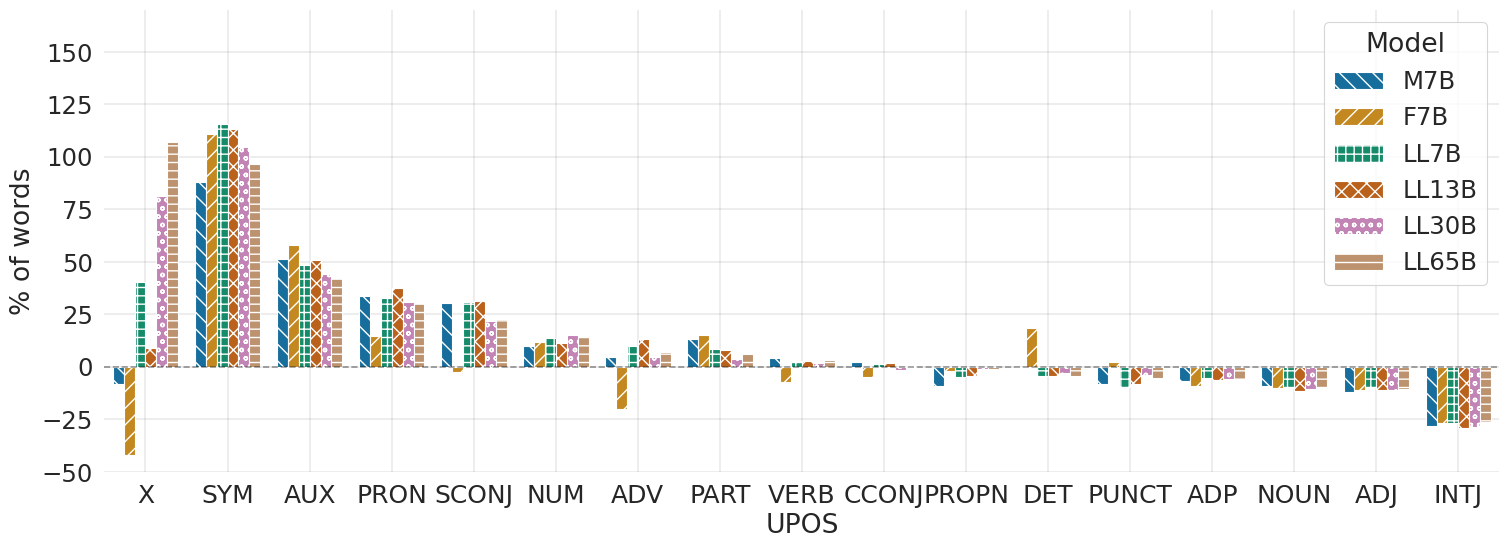

In [42]:
compare_df = relative_df.copy()

compare_df['LL7B'] = (compare_df['llama_7B']-compare_df['original'])*100
compare_df['LL13B'] = (compare_df['llama_13B']-compare_df['original'])*100
compare_df['LL30B'] = (compare_df['llama_30B']-compare_df['original'])*100
compare_df['LL65B'] = (compare_df['llama_65B']-compare_df['original'])*100
compare_df['M7B'] = (compare_df['mistral_7B']-compare_df['original'])*100
compare_df['F7B'] = (compare_df['falcon_7B']-compare_df['original'])*100
compare_df.drop(columns=['original'], inplace=True)
compare_df = compare_df.reset_index()

# sort by llama_65B
compare_df = compare_df.sort_values(by=['llama_65B'], ascending=False)

compare_df  = pd.melt(compare_df, id_vars=['upos'], value_vars=['M7B', 'F7B', 'LL7B', 'LL13B', 'LL30B', 'LL65B'], var_name='lm', value_name='diff')
sns.set(context='paper', font_scale=2)

# create a custom color palette
palette = sns.color_palette("colorblind", 7)

# set white background
# create a new figure with a larger size
plt.figure(figsize=(18, 6))


sns.set_style("whitegrid")
barplot = sns.barplot(data=compare_df, x="upos", y="diff", hue="lm", palette=palette)
sns.despine(top=True, right=True, left=True, bottom=True)

num_hatches = len(compare_df['upos'].unique())

hatches = ['\\\\', '//', '++', 'xx', 'oo', '--']
model_hatches = {model: hatches[i % len(hatches)] for i, model in enumerate(compare_df['lm'].unique())}
for i, thisbar in enumerate(barplot.patches):
    model = compare_df['lm'].unique()[i // num_hatches]
    thisbar.set_hatch(model_hatches[model])

# scatterplot
plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.8, axis='both')
# change legend elements to Human, 7B, 13B, 30B, 65B
# take legend out of the plot
plt.legend(title='Model') #, loc='lower right', bbox_to_anchor=(0.5, 1.5), ncol=6, fancybox=True, shadow=False)
# delete subax2 legend
plt.ylabel('% of words')
plt.xlabel('UPOS')

# same y axis
plt.ylim(-50, 170)
# set background to white

# reduce x-ticks size a bit
plt.tick_params(axis='x', labelsize=18)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.4)

plt.savefig('plots/upos_distribution.png', dpi=300, bbox_inches='tight')

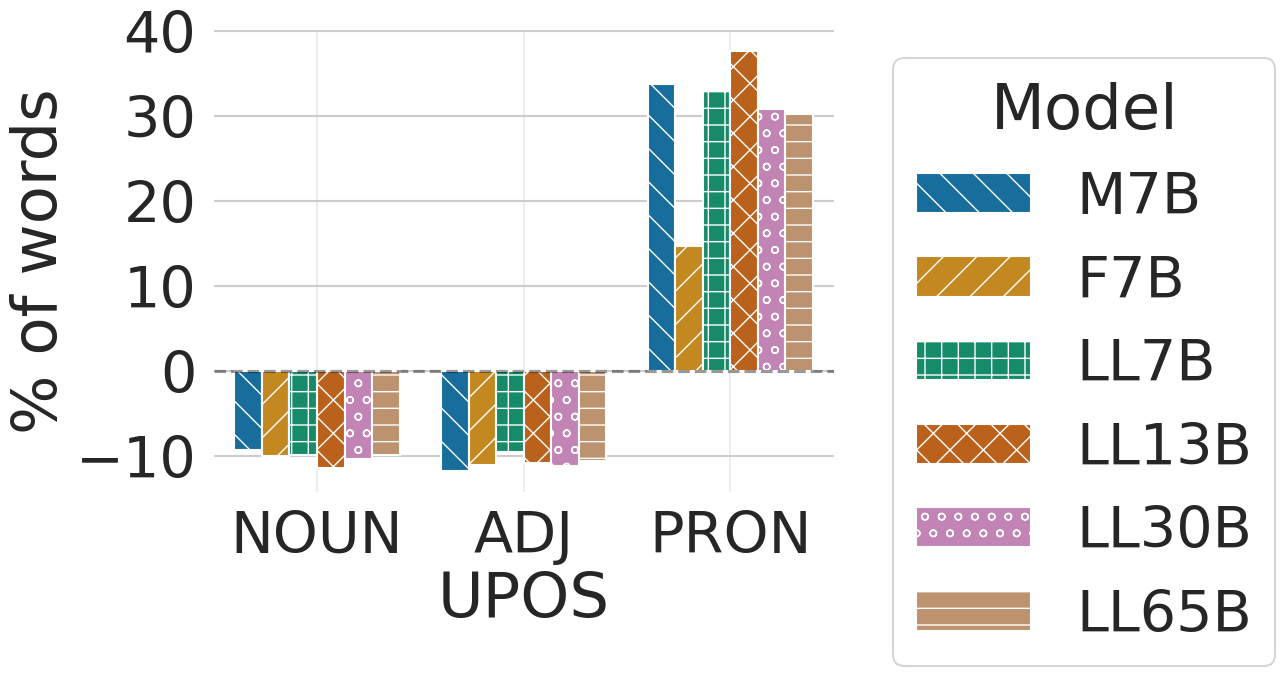

In [43]:
compare_df = relative_df.copy()


compare_df['LL7B'] = (compare_df['llama_7B']-compare_df['original'])*100
compare_df['LL13B'] = (compare_df['llama_13B']-compare_df['original'])*100
compare_df['LL30B'] = (compare_df['llama_30B']-compare_df['original'])*100
compare_df['LL65B'] = (compare_df['llama_65B']-compare_df['original'])*100
compare_df['M7B'] = (compare_df['mistral_7B']-compare_df['original'])*100
compare_df['F7B'] = (compare_df['falcon_7B']-compare_df['original'])*100
compare_df.drop(columns=['original'], inplace=True)
compare_df = compare_df.reset_index()
# only PRON, NOUN, ADJ
compare_df = compare_df[compare_df['upos'].isin(['PRON', 'NOUN', 'ADJ'])]
compare_df = pd.melt(compare_df, id_vars=['upos'], value_vars=['M7B', 'F7B', 'LL7B', 'LL13B', 'LL30B', 'LL65B'], var_name='lm', value_name='diff')
# set context in a graph

sns.set(context='talk', font_scale=2.5)

# create a custom color palette
palette = sns.color_palette("colorblind", 7)
# set white background
# create a new figure with a larger size
plt.figure(figsize=(8, 6))


# move the legend outside of the plot

# set the style to whitegrid
sns.set_style("whitegrid")


# remove the top and right spines

barplot = sns.barplot(data=compare_df, x="upos", y="diff", hue="lm", palette=palette)


num_hatches = len(compare_df['upos'].unique())

hatches = ['\\', '/', '+', 'x', 'o', '-']
model_hatches = {model: hatches[i % len(hatches)] for i, model in enumerate(compare_df['lm'].unique())}
for i, thisbar in enumerate(barplot.patches):
    model = compare_df['lm'].unique()[i // num_hatches]
    thisbar.set_hatch(model_hatches[model])

sns.despine(top=True, right=True, left=True, bottom=True)

# scatterplot
plt.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.8, axis='x')
# change legend elements to Human, 7B, 13B, 30B, 65B
# legend outside plot
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel('% of words')
plt.xlabel('UPOS')


 
# horizontal line
plt.axhline(y=0, color='black', linestyle='--', alpha=0.4)
plt.savefig('plots/upos_comp_plot.png', dpi=300, bbox_inches='tight')

sns.set(context='paper', style="whitegrid", font_scale=2)


scp -r lys@10.68.58.15:/home/lys/syntax_comp/plots/ C:\Users\alber\Desktop\syntax_comp